In [1]:
from mtspark import get_spark, to_pandas
import pandas as pd
from IPython.display import clear_output
from pyspark.sql import functions as F, Window

In [3]:
spark = get_spark({
    'appName': 'prepare_alien_targets',
    'spark.yarn.queue': 'fin_users',
    'spark.ui.showConsoleProgress': 'false',
    'spark.executor.cores': 4,
    'spark.executor.memory': '25g',
    'spark.driver.memory': '32g',
    'spark.driver.maxResultSize': '128g',
    'spark.kryoserializer.buffer.max': '512m',
    "spark.hadoop.hive.warehouse.data.skiptrash": "true",
    'spark.jars.packages': 'ru.mts.bigdata.onetools:mtspark-scala-functions_2.12:1.0.4',
}, spark_version='local')
clear_output()

# Сбор таргета
Была написана специальная функция по отбору номеров неабонентов - клиентов МТСБ (на дату n у него было оформлено подписки), результат записан в таблицу rand_0_aafan_target_alien_cc_apr_sept_2024. Строк получилось не ошеломляюще много в виду специфической логики.

In [5]:
pre_target = spark.table('leadgen_sb.rand_0_aafan_target_alien_cc_apr_sept_2024')
pre_target.select('msisdn').distinct().count()

4709696

In [6]:
pre_target.columns

['msisdn',
 'client_id',
 'business_dt_orig',
 'target',
 'window_start',
 'business_dt_sunday']

In [7]:
pre_target.groupBy('target').count().show()

+------+-------+
|target|  count|
+------+-------+
|     1|  41643|
|     0|4668053|
+------+-------+



In [8]:
total_rows = pre_target.count()
result = pre_target.groupBy('target').count()
result.withColumn('percent', (F.col('count') / total_rows) * 100).show()

+------+-------+------------------+
|target|  count|           percent|
+------+-------+------------------+
|     1|  41643|0.8841971965918819|
|     0|4668053| 99.11580280340812|
+------+-------+------------------+



In [9]:
min_date_df = pre_target.select(F.min('window_start'))
min_date = min_date_df.collect()[0][0].strftime('%Y-%m-%d')

max_date_df = pre_target.select(F.max('business_dt_orig'))
max_date = max_date_df.collect()[0][0].strftime('%Y-%m-%d')

In [10]:
print(min_date, max_date)

2024-03-18 2024-09-30


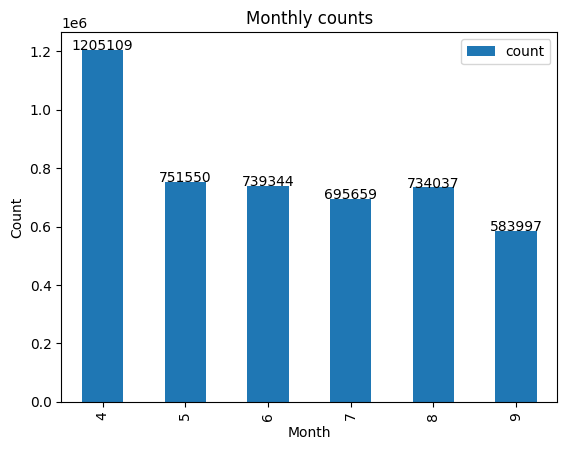

In [17]:
pre_target = pre_target.withColumn('month', month(pre_target['business_dt_orig']))

monthly_counts = pre_target.groupBy('month').count().orderBy('month')

monthly_counts_pd = monthly_counts.toPandas()

ax = monthly_counts_pd.plot(kind='bar', x='month', y='count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly counts')

for i, v in enumerate(monthly_counts_pd['count']):
    ax.text(i, v + 50, str(v), ha='center')

plt.show()

# Граф звонков

In [11]:
calls = spark.table('leadgen_sb.rand_0_aafan_graph_calls_alien_cc_apr_sept_2024')

In [12]:
calls.count()

296722403

In [13]:
# Уникальных пользователей стало меньше, так как не все они могли совершать звонки
calls.select('msisdn').distinct().count()

3509385

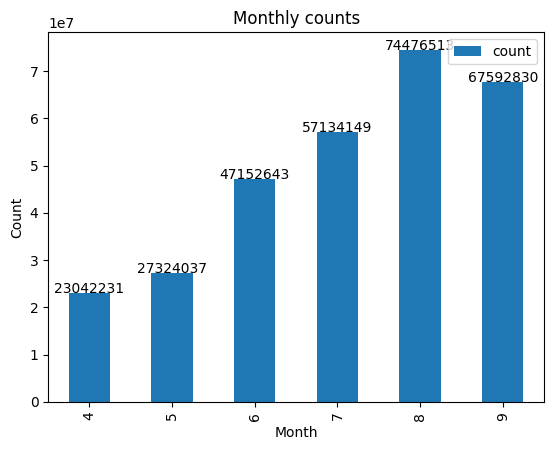

In [15]:
from pyspark.sql.functions import month
import matplotlib.pyplot as plt

calls = calls.withColumn('month', month(calls['business_dt']))

monthly_counts = calls.groupBy('month').count().orderBy('month')

monthly_counts_pd = monthly_counts.toPandas()

ax = monthly_counts_pd.plot(kind='bar', x='month', y='count')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Monthly counts')

for i, v in enumerate(monthly_counts_pd['count']):
    ax.text(i, v + 50, str(v), ha='center')

plt.show()